Code Created by Florent Poux. 
This is part of a joint work with:
* Prof. Sander Oude Elberink, 
* Prof. Mila Koeva, 
* Prof. Ville Lehtola, 
* Prof. Nourian Pirouz, 
* Prof. Paulo Raposo.

Licence MIT, worked done with UTWENTE. Please refer to the article for the full comprehension.

Members of the [ITC UTWENTE](https://www.itc.nl/) or students enrolled in a Program can use the code with privileged IP Rights. 

*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   Make sure to modify the paths to your dataset, either locally stored, on the CRIB, or in your Drive.
*   You are free to reuse in your own project, please use the followinf reference if so: XXX

For assistance:  [Linkedin](https://www.linkedin.com/in/florent-poux-point-cloud/), [Medium](https://medium.com/@florentpoux) or [Twitter](https://twitter.com/PouxPointCloud).

Enjoy!

# Step 3: Python Automation

# 3.1. Importing libraries

In [1]:
import sys
import os
#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#3D Libraries
import open3d as o3d
import laspy
print(laspy.__version__)

#GLB Libraries
from pygltflib import GLTF2

#Geospatial libraries
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon

import copy
import time
# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

import open3d.core as o3c

if o3d.__DEVICE_API__ == 'cuda':
    import open3d.cuda.pybind.t.pipelines.registration as treg
else:
    import open3d.cpu.pybind.t.pipelines.registration as treg



print(f"Open 3D Version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3
Open 3D Version: 0.18.0


# 3.2. Loading 3D datasets

We define the specific paths to our dataset:

In [2]:
data_folder="../DATA/"
pc_dataset="28GN1_08_sampled.xyz"
mesh_dataset="pijlkruid_bag.ply"
glb_dataset="pijlkruid.glb" # model.glb
result_folder="../DATA/RESULTS/"

We can prepare the point cloud by first creating a Pandas DataFrame object called pcd_df, which will host the point cloud data:

In [3]:
# pcd_df= pd.read_csv(data_folder+pc_dataset, delimiter=";")
# print(pcd_df.columns)

Numpy to Open3D

In [4]:
# pcd_o3d=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(pcd_df[['X','Y','Z']])))
# pcd_o3d.colors=o3d.utility.Vector3dVector(np.array(pcd_df[['R','G','B']])/255)
# pcd_o3d

Loading the Mesh dataset (3DBAG)

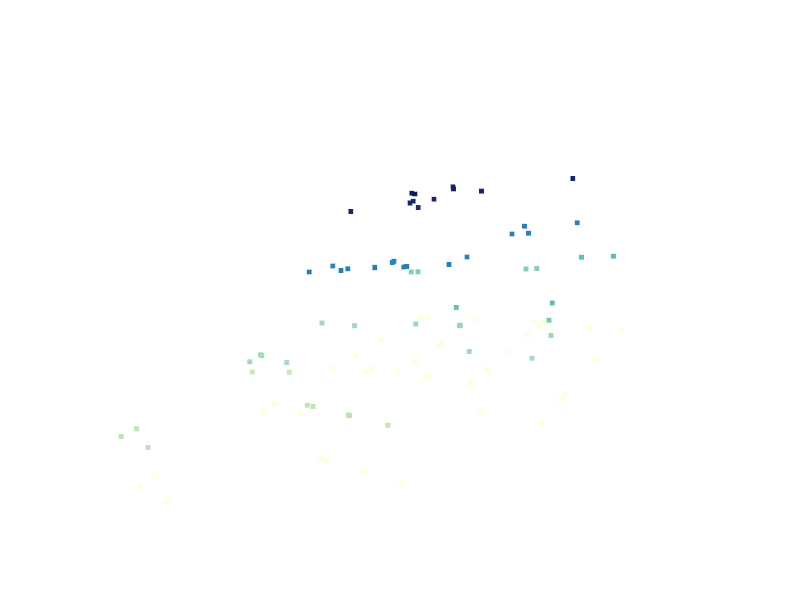

Read the combined point cloud
PointCloud with 105 points.
[2.42184276e+05 4.85148072e+05 1.39880527e+01]
[2.42193750e+05 4.85157531e+05 2.04165001e+01]
[2.42175141e+05 4.85136031e+05 1.10434999e+01]


In [3]:
#READ .PLY combined point cloud
mesh = (data_folder+mesh_dataset)
mesh_pcd = o3d.io.read_point_cloud(mesh)
o3d.visualization.draw_geometries([mesh_pcd], window_name="Overlay of Point Cloud and Mesh", width=800, height=600)

print("Read the combined point cloud")
print(mesh_pcd)

print(mesh_pcd.get_center())
print(np.asarray(mesh_pcd.get_max_bound()))
print(np.asarray(mesh_pcd.get_min_bound()))

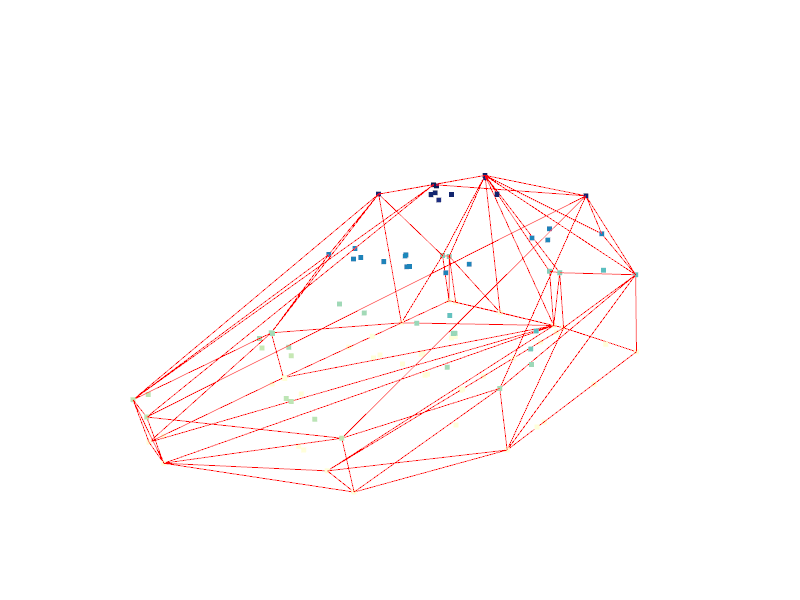

In [4]:
#Convex hull
hull,_=mesh_pcd.compute_convex_hull()
hull_ls=o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([mesh_pcd,hull_ls], window_name="Convex Hull", width=800, height=600)

Loading a glb model

TriangleMesh with 127443 points and 229021 triangles.
Glb center:
[ 8.26452045 -8.58277743  2.2474791 ]


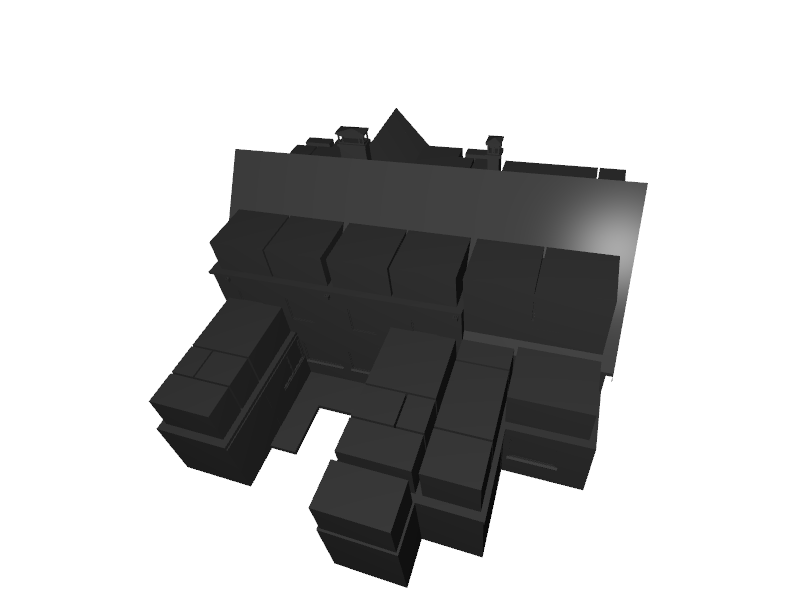

In [7]:
glb = o3d.io.read_triangle_mesh(data_folder+glb_dataset, enable_post_processing=True, print_progress=True)
# Swap y and z coordinates
vertices = np.asarray(glb.vertices)
vertices = vertices[:, [0, 2, 1]]  # Swap y and z coordinates
# Mirror x coordinates
vertices[:, 0] = -vertices[:, 0]

glb.vertices = o3d.utility.Vector3dVector(vertices)

glb.paint_uniform_color([0.2, 0.2, 0.2])
print(glb)
print("Glb center:")
print(glb.get_center())
glb.compute_vertex_normals()
o3d.visualization.draw_geometries([glb], window_name="GLB Mesh", width=800, height=600)


# Rotation function

In [8]:
def rotation_matrix(axis, angle, is_degree=True):
    """Generate a rotation matrix given an axis and an angle.
    Args:
        axis (str): 'x', 'y', or 'z' axis to rotate around.
        angle (float): The angle to rotate by.
        is_degree (bool): If True, the angle is in degrees, otherwise radians.

    Returns:
        numpy.ndarray: The rotation matrix.
    """
    if is_degree:
        angle = np.radians(angle)
    c, s = np.cos(angle), np.sin(angle)
    if axis == 'x':
        return np.array([
            [1, 0, 0],
            [0, c, -s],
            [0, s, c]
        ])
    elif axis == 'y':
        return np.array([
            [c, 0, s],
            [0, 1, 0],
            [-s, 0, c]
        ])
    elif axis == 'z':
        return np.array([
            [c, -s, 0],
            [s, c, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")

# 3.3. Python 3D Visualization

To vizualise in Open3D in the specific viewer, all we have to do is to pass a python list of objects to visualize. Our list is thus composed of one Open3D PointCloud, and one Open3D TriangleMesh, which gives [pcd_o3d,mesh]. Let us visualize this combination in a standalone window with:

In [9]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

# Aligning GLB model to 3D Bag object

Translation of the 3d object for rough alignment

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 2.42176012e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 4.85156655e+05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.17405736e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


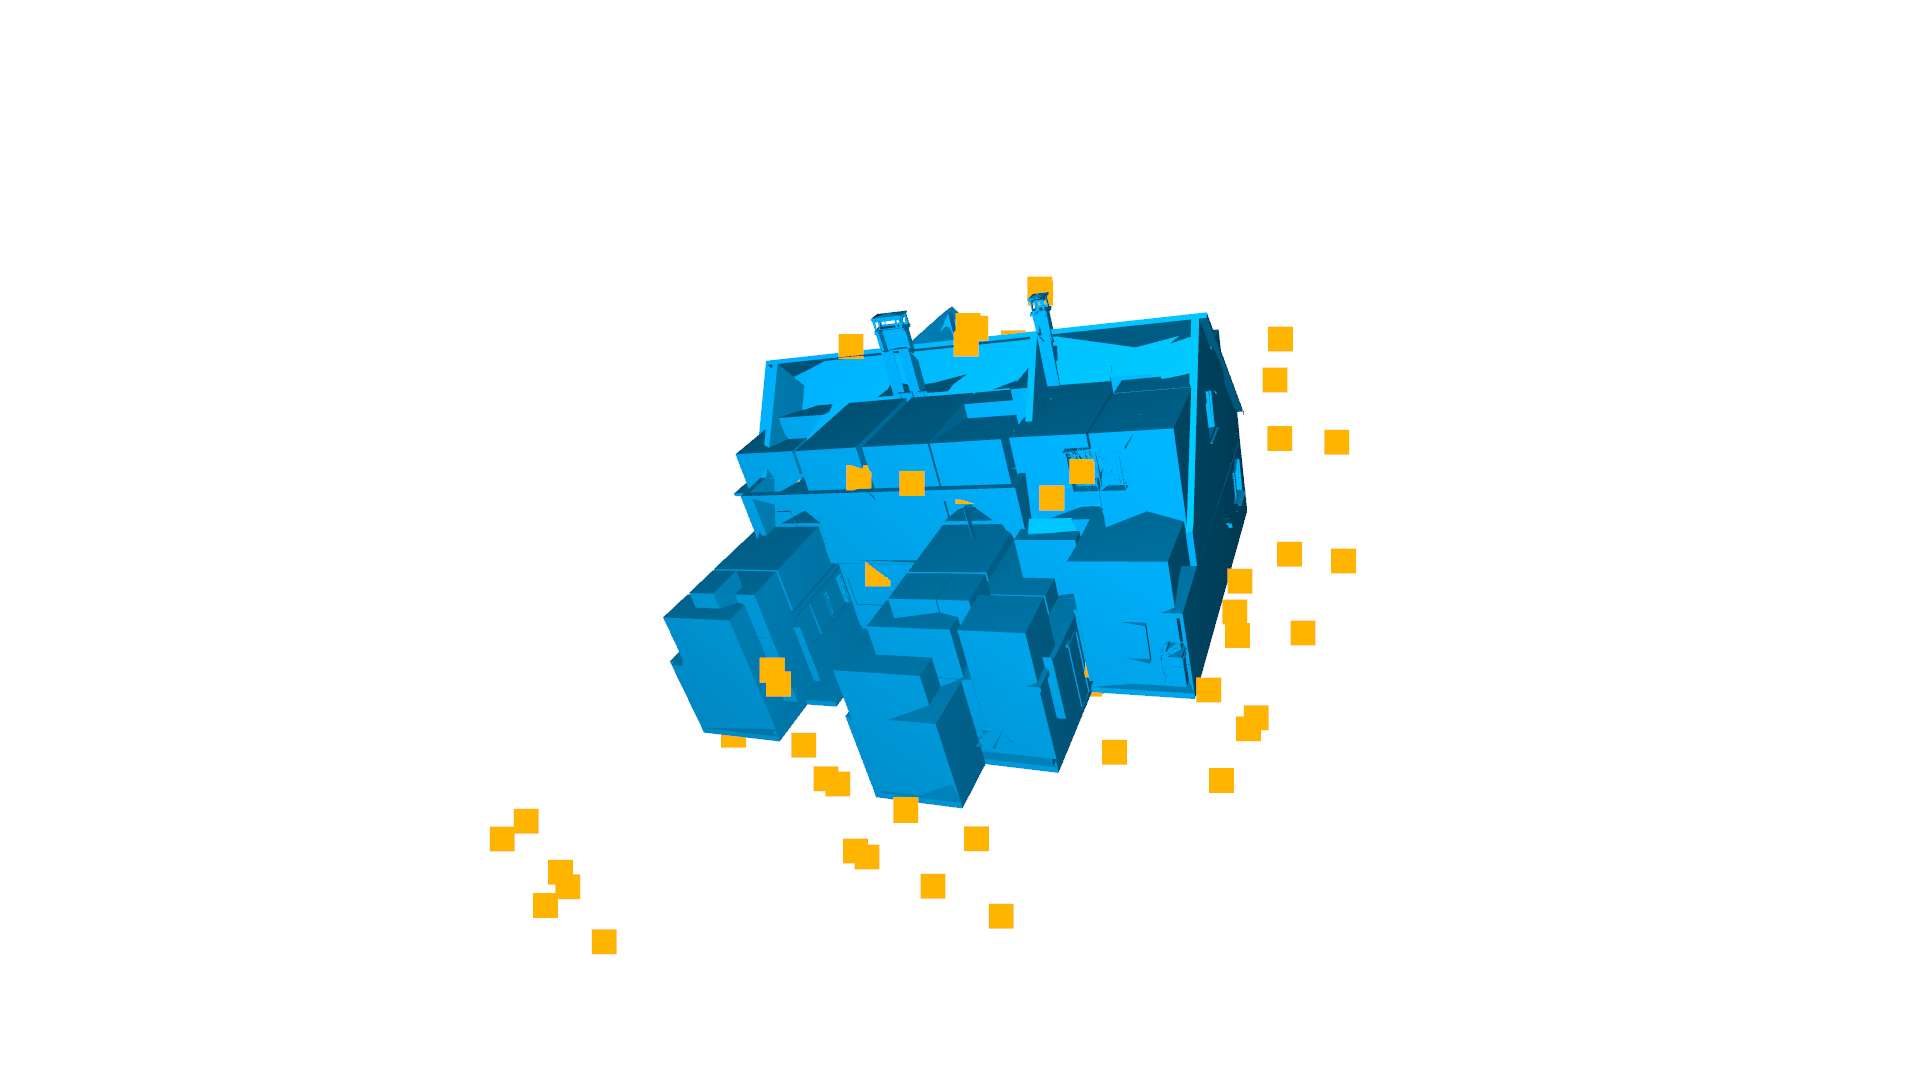

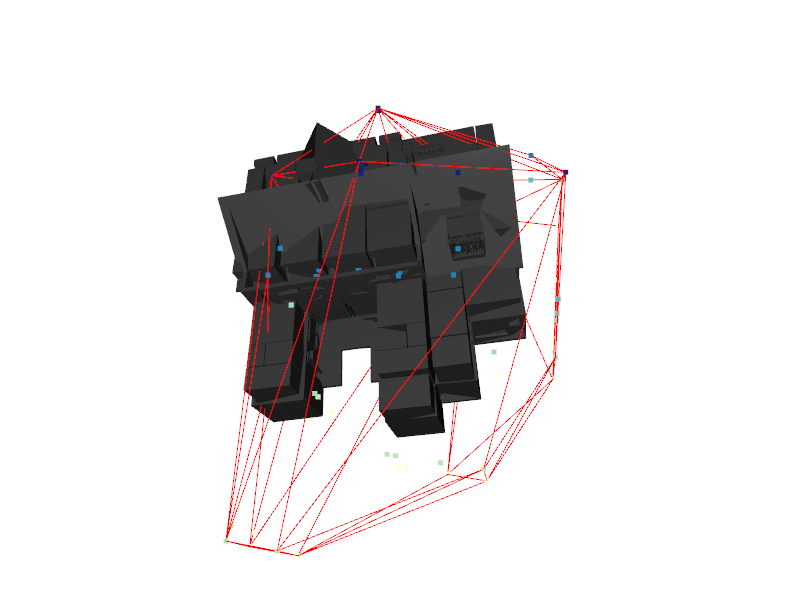

[2.42184276e+05 4.85148072e+05 1.39880527e+01]
[2.42184276e+05 4.85148072e+05 1.39880527e+01]


In [10]:
# Get the translation matrix
T=np.identity(4)	# Create an identity matrix
T[:3,3]=np.array(mesh_pcd.get_center())-np.array(glb.get_center()) # Set the translation values to the difference between the centers of the two point clouds
print(T)
glb_t = copy.deepcopy(glb) # Create a copy of the glb mesh
glb_t.transform(T)  # Apply the translation matrix to the glb mesh
draw_registration_result(mesh_pcd, glb_t, np.identity(4))

# Draw the registration result
o3d.visualization.draw_geometries([glb_t, mesh_pcd, hull_ls], window_name="Overlay of Point Cloud and Mesh", width=800, height=600)
print(mesh_pcd.get_center())
print(glb_t.get_center())
# draw_registration_result(mesh_pcd, glb_t, np.identity(4))


[[ 0.96208474  0.27275071  0.        ]
 [-0.27275071  0.96208474  0.        ]
 [ 0.          0.          1.        ]]


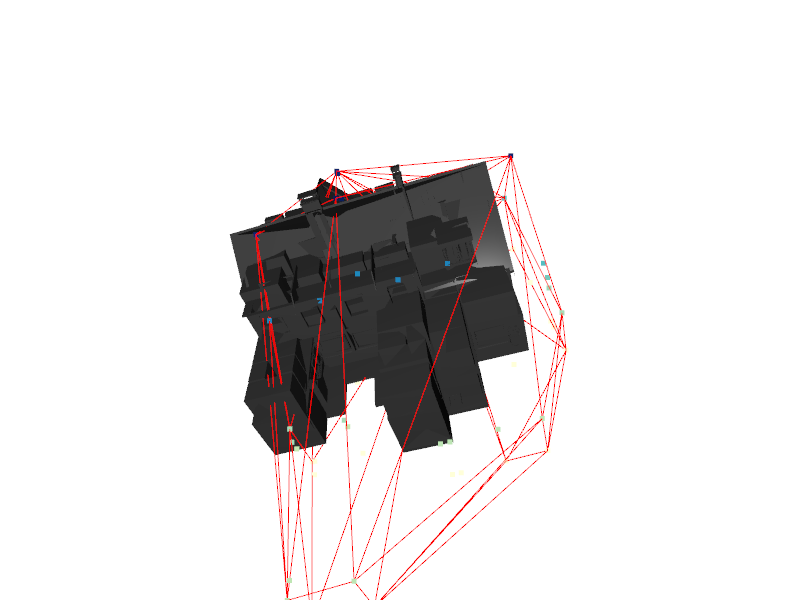

In [11]:
R =rotation_matrix('z', -15.828015916710607) # Generate a rotation matrix to rotate the glb mesh 168 degrees around the z-axis
R = np.dot(R, rotation_matrix('x', 0)) # Generate a rotation matrix to rotate the glb mesh 90 degrees around the x-axis
# R = np.dot(R, rotation_matrix('y', -10)) # Generate a rotation matrix to rotate the glb mesh 90 degrees around the y-axis

print(R)
# Apply the rotation matrix to the glb mesh
glb_r = copy.deepcopy(glb_t)
glb_r.rotate(R, center=glb_r.get_center())


# Draw the registration result
o3d.visualization.draw_geometries([glb_r, mesh_pcd, hull_ls], window_name="Overlay of Point Cloud and Mesh", width=800, height=600)
# draw_registration_result(mesh_pcd, glb_r, np.identity(4))

# Global registration
Both [ICP registration](../pipelines/icp_registration.ipynb) and [Colored point cloud registration](colored_pointcloud_registration.ipynb) are known as local registration methods because they rely on a rough alignment as initialization. This tutorial shows another class of registration methods, known as **global** registration. This family of algorithms do not require an alignment for initialization. They usually produce less tight alignment results and are used as initialization of the local methods.

## Extract geometric feature
We downsample the point cloud, estimate normals, then compute a FPFH feature for each point. The FPFH feature is a 33-dimensional vector that describes the local geometric property of a point. A nearest neighbor query in the 33-dimensinal space can return points with similar local geometric structures. See [\[Rasu2009\]](../reference.html#rasu2009) for details.

In [12]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

## Input
This code below reads a source point cloud and a target point cloud from two files. They are misaligned with an identity matrix as transformation.

In [13]:
# def prepare_dataset(voxel_size):
#     print(":: Load two point clouds and disturb initial pose.")

#     source = mesh_pcd
#     glb_pcd = o3d.geometry.PointCloud()
#     glb_pcd.points = glb_r.vertices
#     glb_pcd.normals = glb_r.vertex_normals
#     target = glb_pcd
#     trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
#                              [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
#     source.transform(trans_init)
#     draw_registration_result(source, target, np.identity(4))

#     source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
#     target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
#     return source, target, source_down, target_down, source_fpfh, target_fpfh

In [13]:
# # prepare data set
# voxel_size = 0.05  # means 5cm for this dataset
# source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
#     voxel_size)
voxel_size = 0.05  # means 5cm for the dataset
source_down, source_fpfh = preprocess_point_cloud(mesh_pcd, voxel_size)

# # Convert GLB mesh to point cloud for ICP
glb_pcd = o3d.geometry.PointCloud()
glb_pcd.points = glb_r.vertices
glb_pcd.normals = glb_r.vertex_normals
glb_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))

target_down, target_fpfh = preprocess_point_cloud(glb_pcd, voxel_size)

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [14]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[Open3D WARNING] Too few correspondences (3) after mutual filter, fall back to original correspondences.
RegistrationResult with fitness=4.081633e-02, inlier_rmse=2.961270e-02, and correspondence_set size of 4
Access transformation to get result.


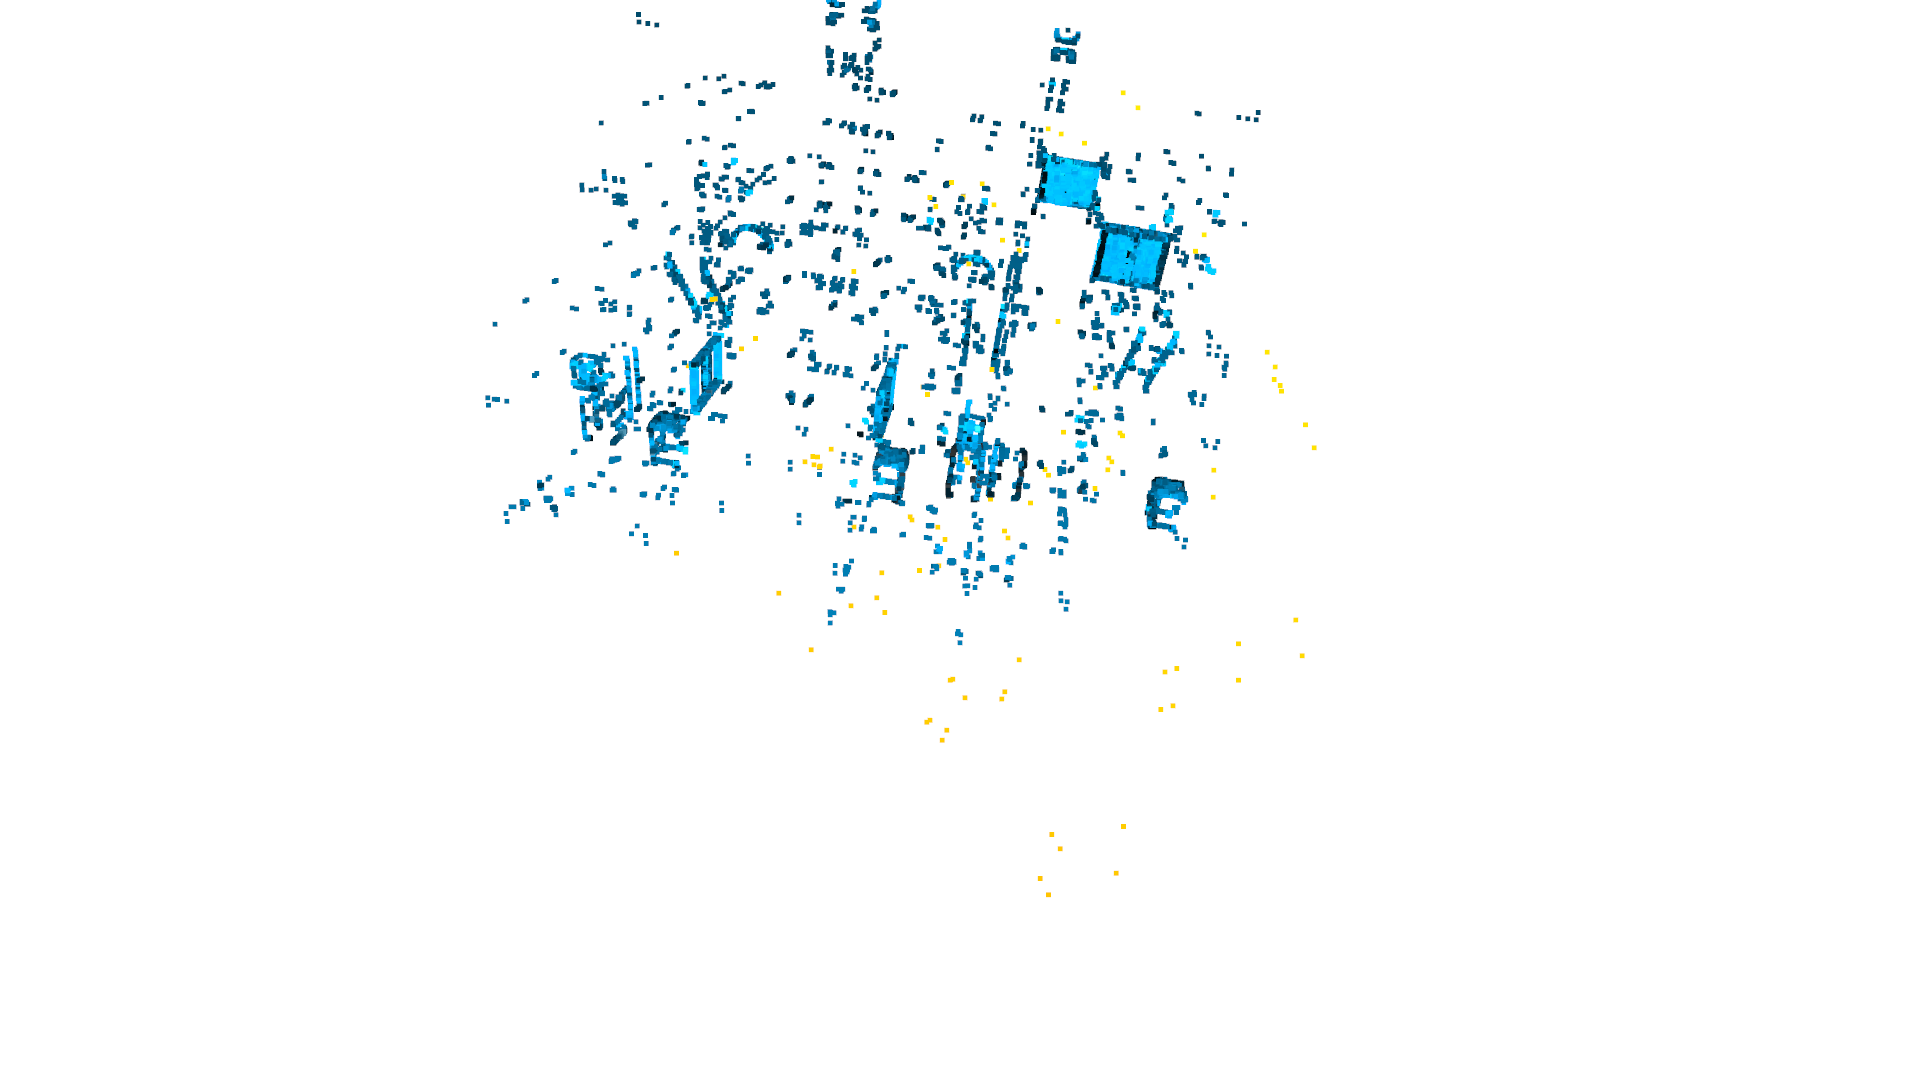

RANSAC registration result
[[ 5.72943585e-01 -6.78995945e-01 -4.59020866e-01  4.32849446e+05]
 [-1.23249286e-01  4.82311489e-01 -8.67286136e-01  2.81019212e+05]
 [ 8.10274807e-01  5.53480022e-01  1.92651508e-01 -4.64749206e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


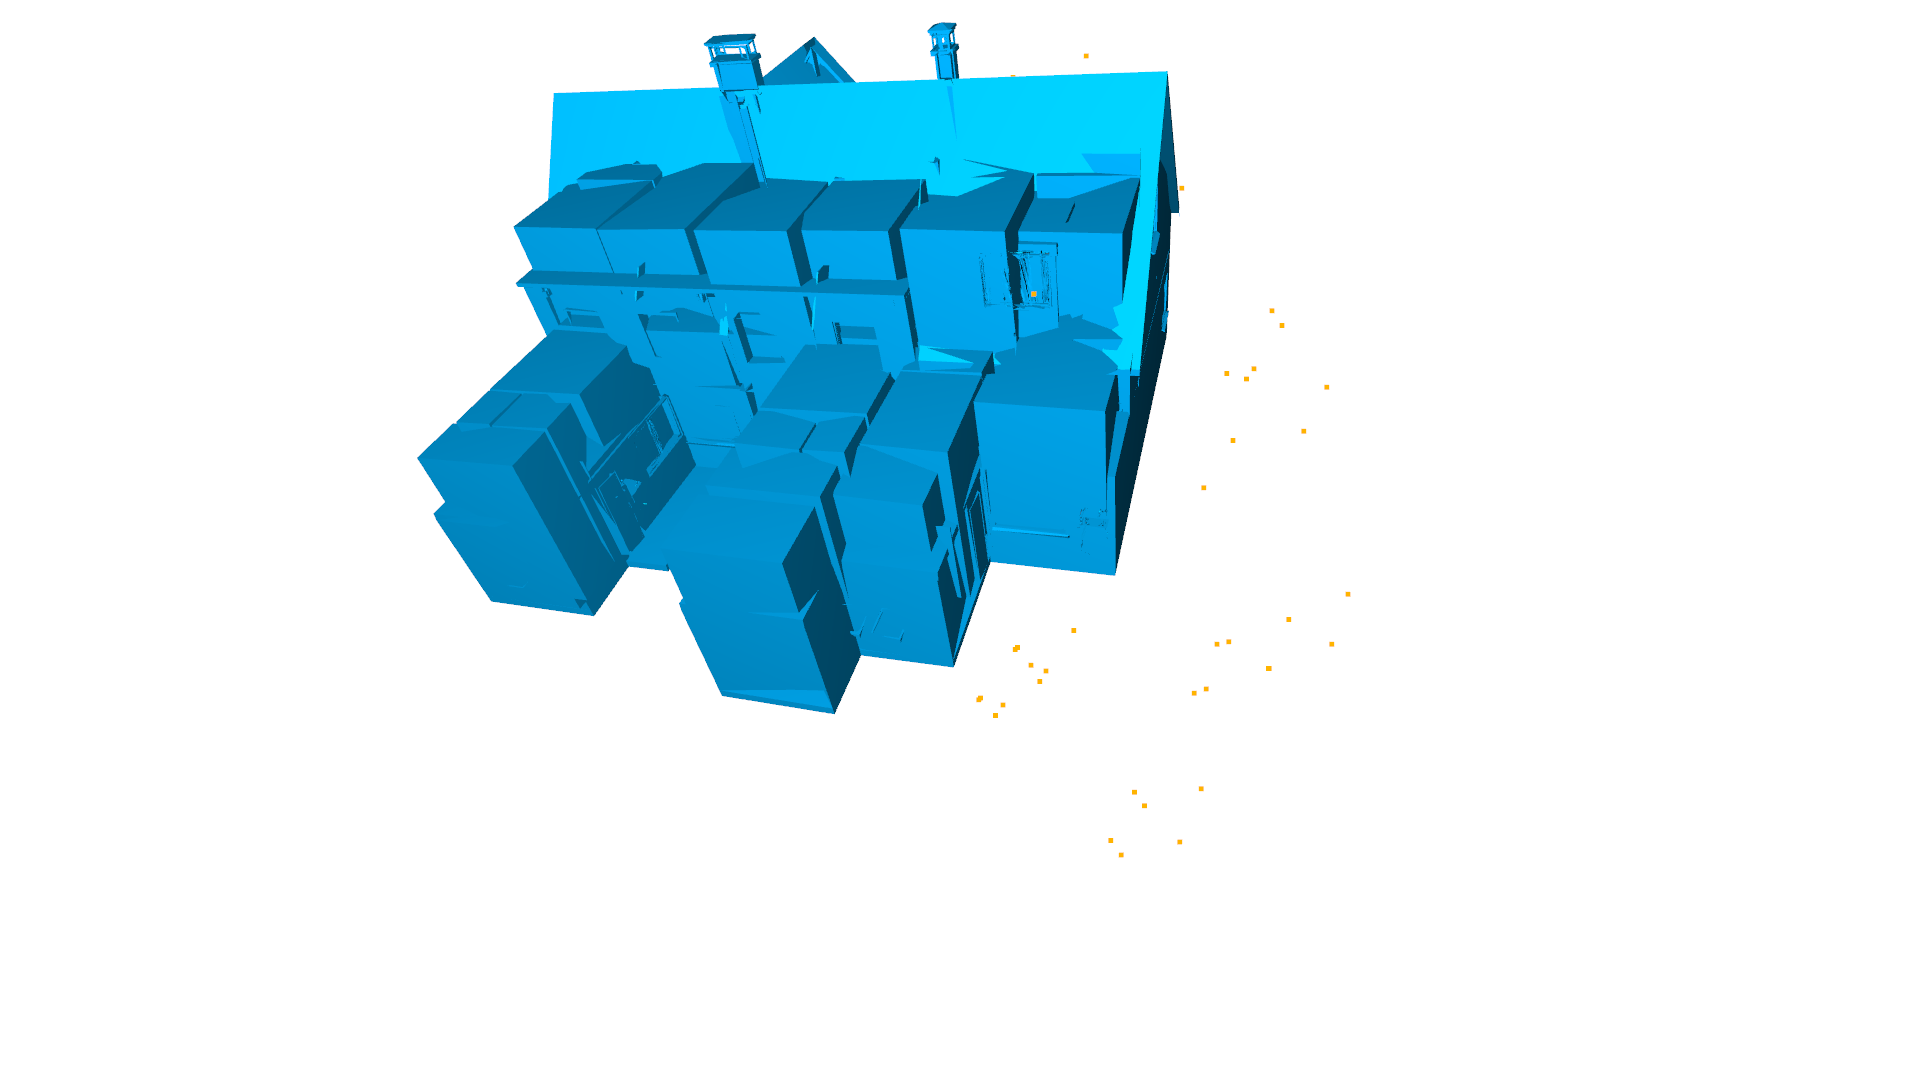

In [15]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)
print("RANSAC registration result")
print(result_ransac.transformation)
draw_registration_result(mesh_pcd, glb_r, result_ransac.transformation)

## Local refinement
For performance reason, the global registration is only performed on a heavily down-sampled point cloud. The result is also not tight. We use [Point-to-plane ICP](../icp_registration.ipynb#point-to-plane-ICP) to further refine the alignment.

In [16]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


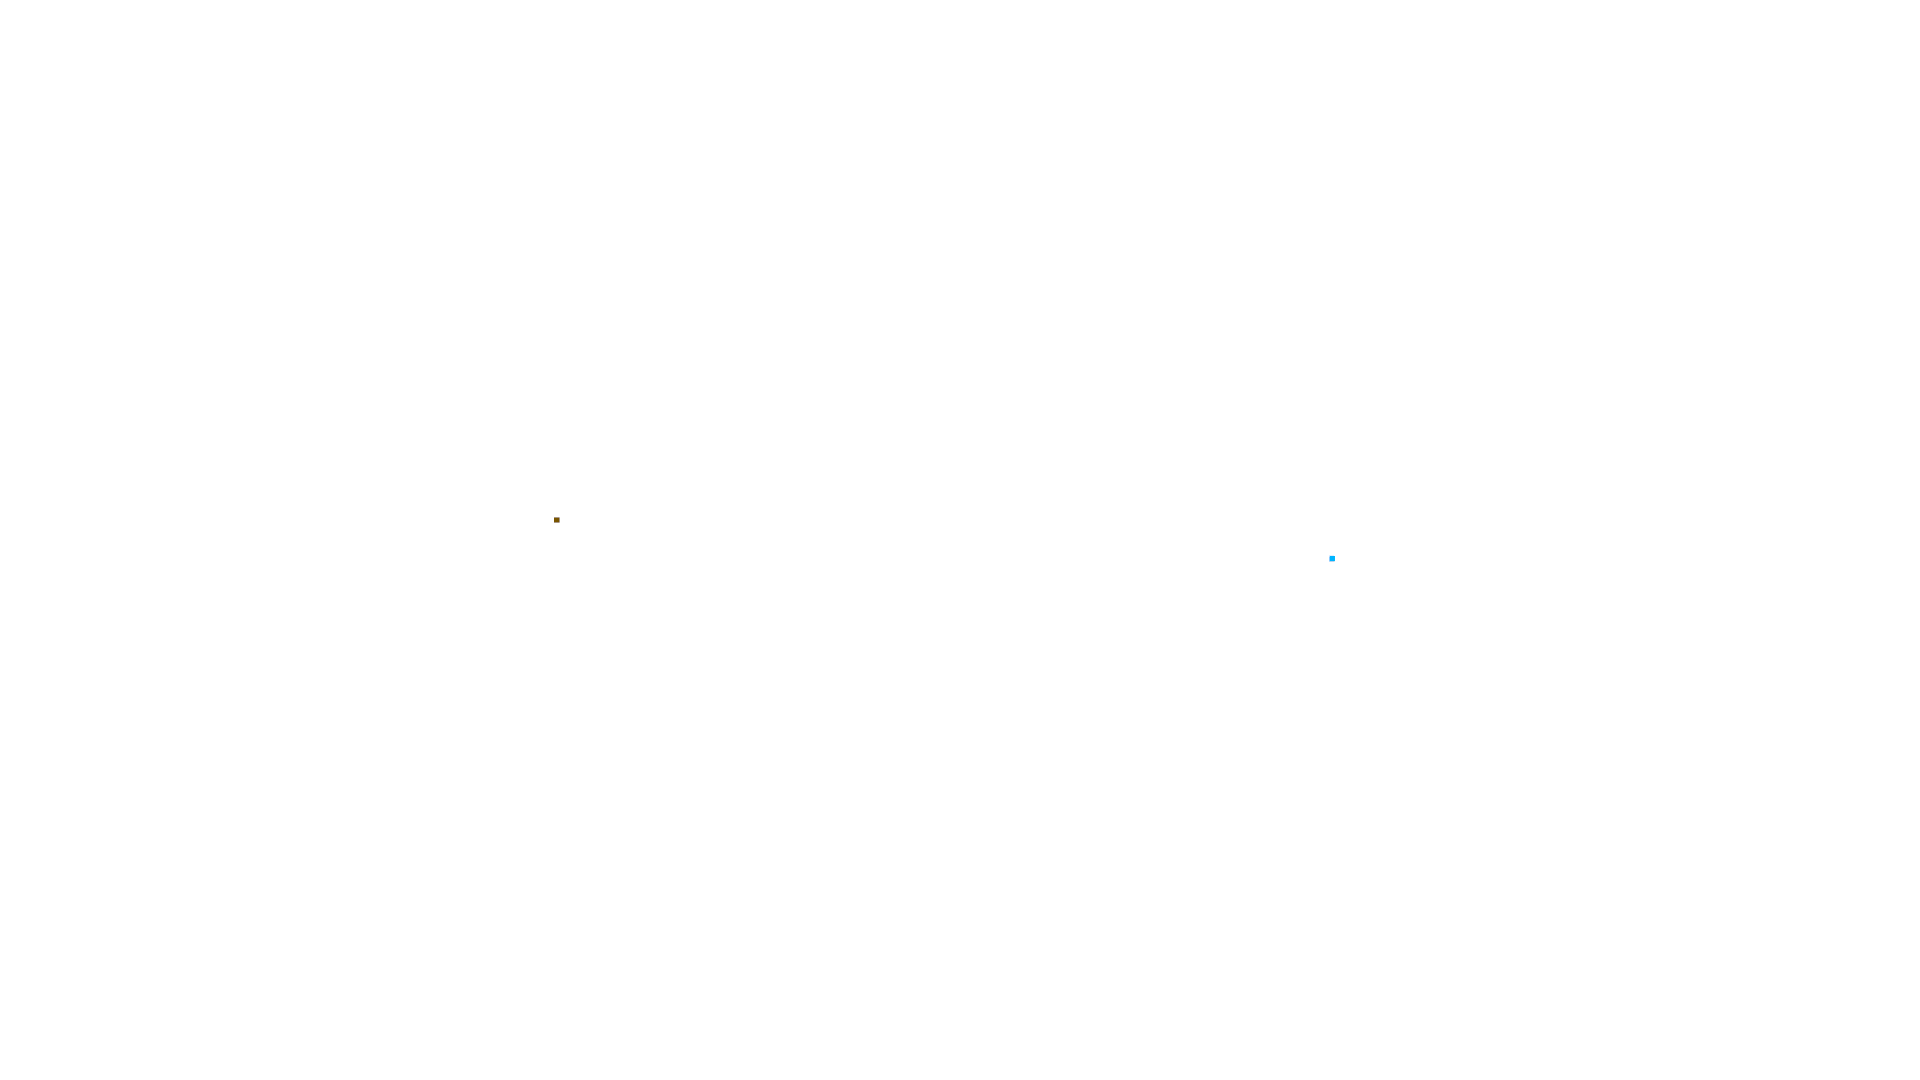

In [17]:
result_icp = refine_registration(source_down, target_down, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(source_down, target_down, result_icp.transformation)

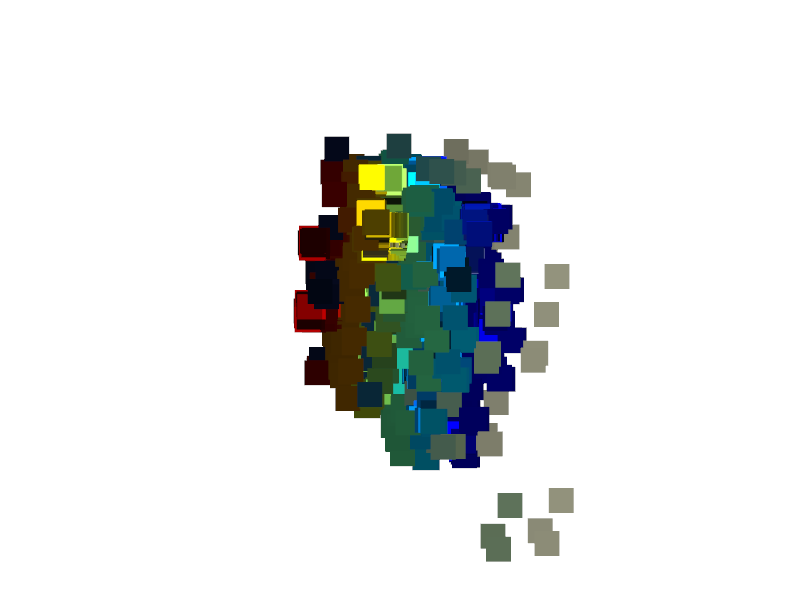

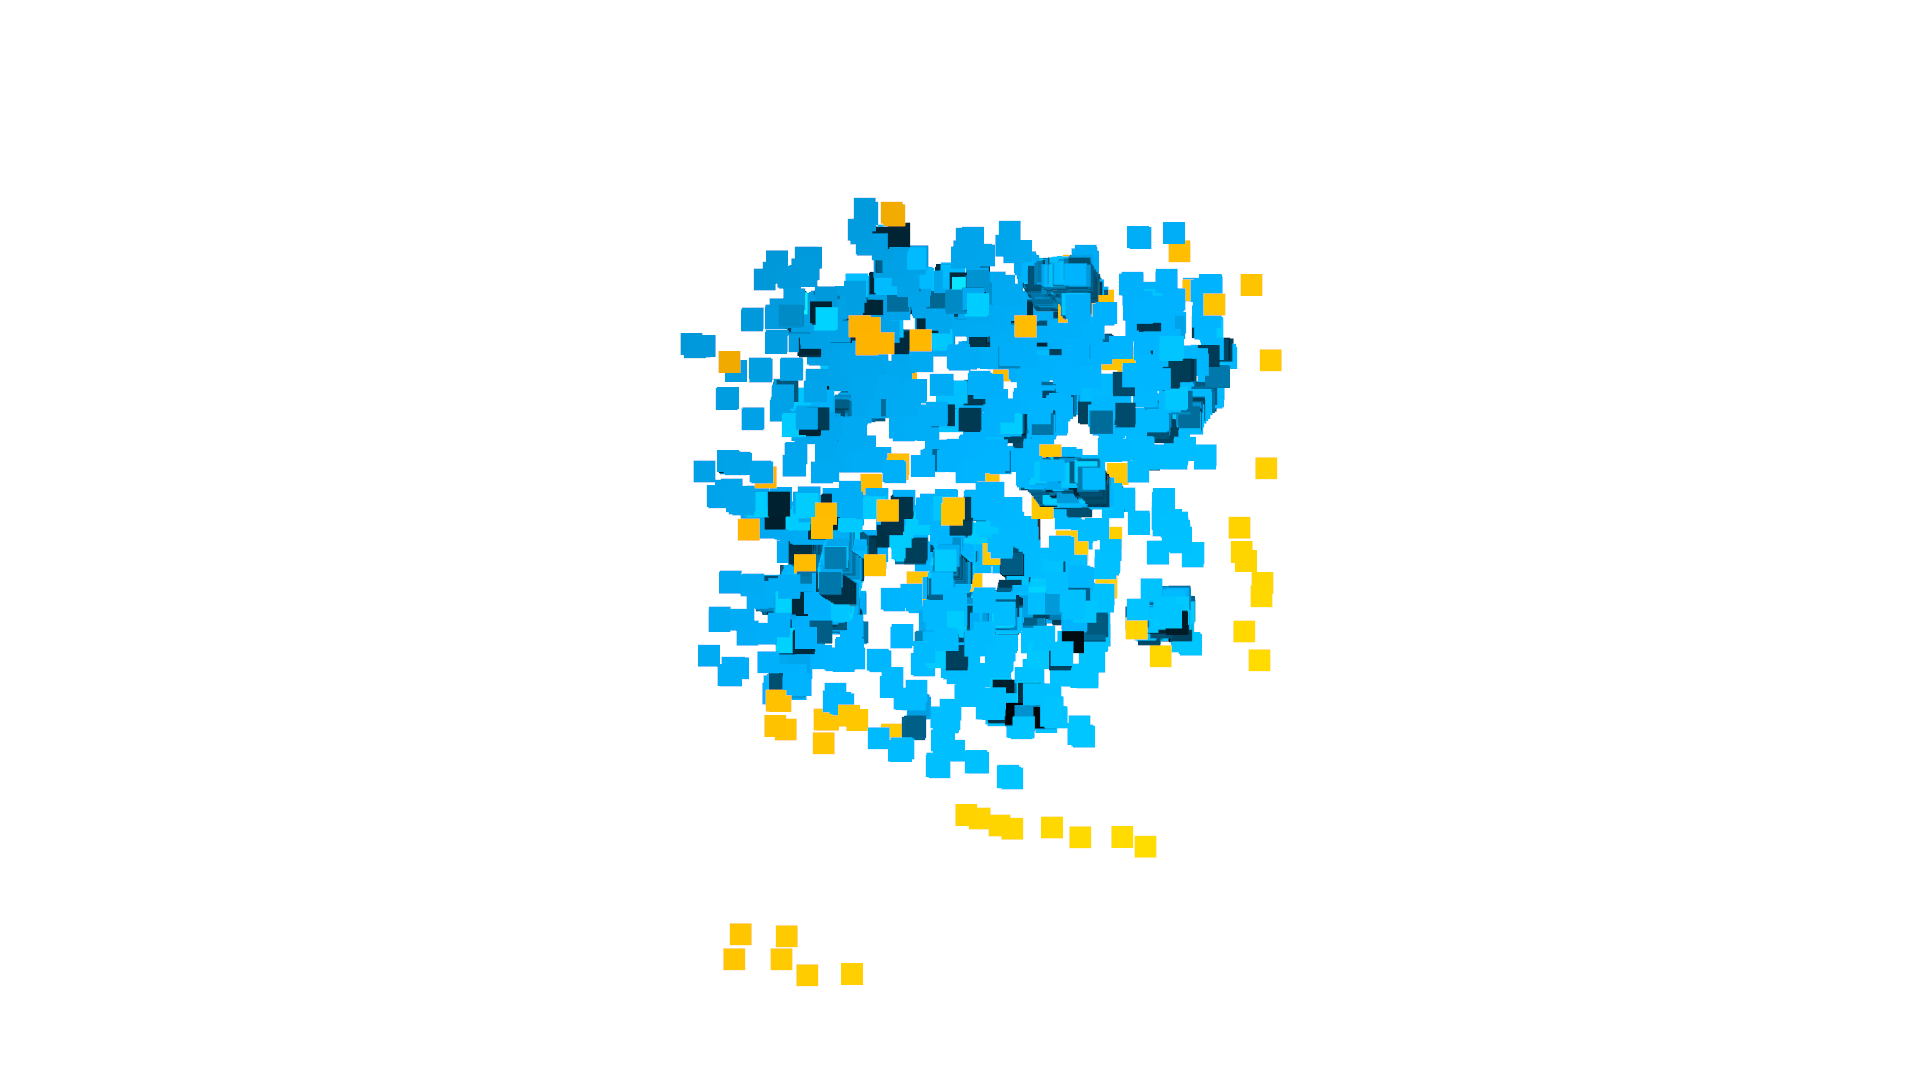

In [18]:
# # Convert GLB mesh to point cloud for ICP
# glb_pcd = o3d.geometry.PointCloud()
# glb_pcd.points = glb_r.vertices
# glb_pcd.normals = glb_r.vertex_normals

# glb_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# # o3d.visualization.draw_geometries([mesh_pcd, glb_pcd])
# # downsample the point cloud
# voxel_size = 0.05
# glb_pcd_down = glb_pcd.voxel_down_sample(voxel_size)

o3d.visualization.draw_geometries([source_down, target_down], window_name="Downsampled Point Clouds", width=800, height=600)
draw_registration_result(source_down, target_down, np.identity(4))

## Point-to-point ICP
In general, the ICP algorithm iterates over two steps:

1. Find correspondence set $\mathcal{K}=\{(\mathbf{p}, \mathbf{q})\}$ from target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$ transformed with current transformation matrix $\mathbf{T}$.
2. Update the transformation $\mathbf{T}$ by minimizing an objective function $E(\mathbf{T})$ defined over the correspondence set $\mathcal{K}$.

Different variants of ICP use different objective functions $E(\mathbf{T})$ [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) [\[Park2017\]](../reference.html#park2017).

We first show a point-to-point ICP algorithm [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) using the objective

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\|\mathbf{p} - \mathbf{T}\mathbf{q}\|^{2}
\end{equation}

The class `TransformationEstimationPointToPoint` provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective. The function `registration_icp` takes it as a parameter and runs point-to-point ICP to obtain the results.

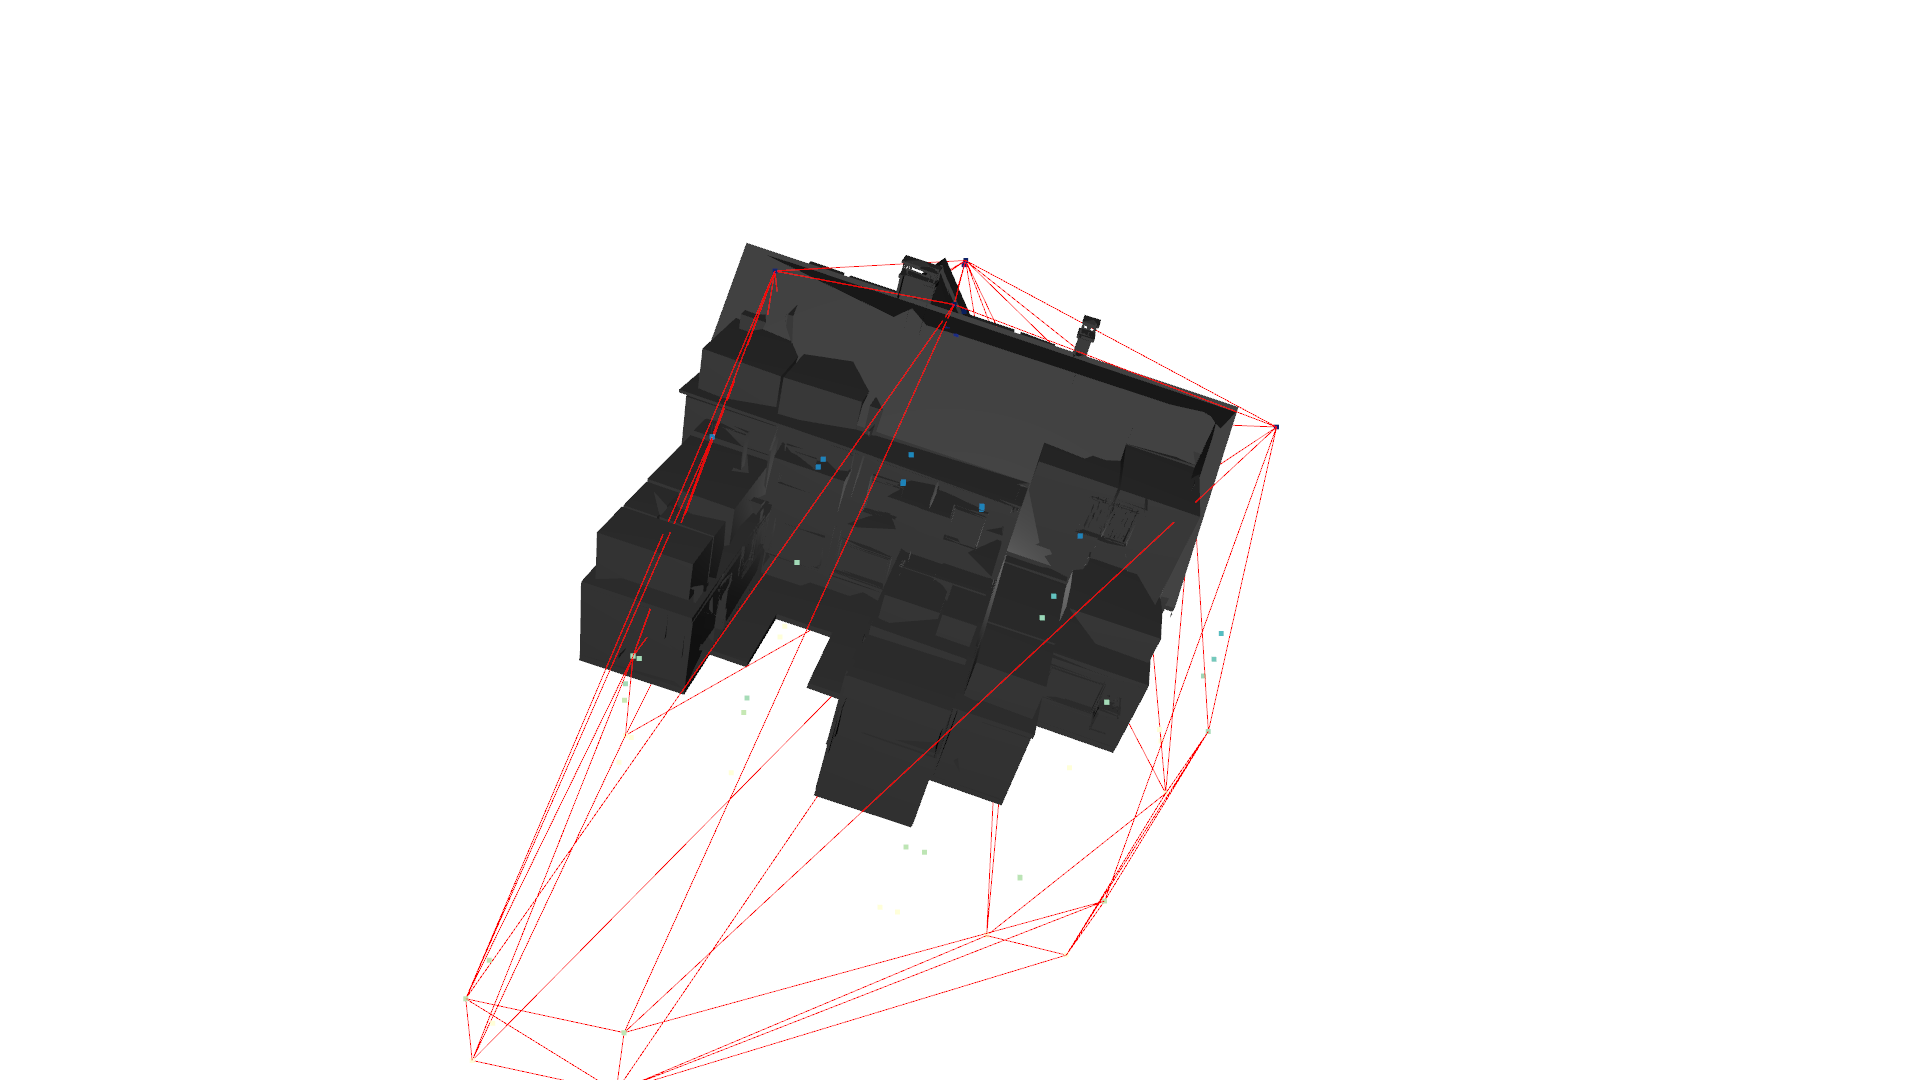

In [19]:
# Perform ICP fine alignment
threshold = 0.5  # Set a larger threshold if needed
icp_result = o3d.pipelines.registration.registration_icp(
    source_down, target_down, threshold, np.eye(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint()
)
# Transform the GLB model based on ICP result
glb_icp = copy.deepcopy(glb_r)
glb_icp.transform(icp_result.transformation)

# Color the mesh with a beautiful gradient
glb_icp.compute_vertex_normals()
glb_icp.paint_uniform_color([0.2, 0.2, 0.2])



# Visualize the aligned models
o3d.visualization.draw_geometries([glb_icp, mesh_pcd, hull_ls], window_name="Aligned GLB and Mesh Point Cloud")

Coloring based on classification.
1=unclassified, 2=Ground, 6=building, 9=water, 26=rest

In [20]:
# Save the aligned GLB model
#o3d.io.write_triangle_mesh(result_folder+"aligned.glb", glb_r)
print("Aligned GLB model saved to aligned.glb")
print("ICP Transformation Matrix:")
print(icp_result.transformation)
print("ICP Fitness Score:")
print(icp_result.fitness)
print("ICP Inlier RMSE:")
print(icp_result.inlier_rmse)


Aligned GLB model saved to aligned.glb
ICP Transformation Matrix:
[[ 9.98460687e-01  5.30608019e-02 -1.61495344e-02 -2.53689906e+04]
 [-5.25225469e-02  9.98103537e-01  3.21046928e-02  1.36403129e+04]
 [ 1.78224082e-02 -3.12070589e-02  9.99354032e-01  1.08235861e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ICP Fitness Score:
0.1326530612244898
ICP Inlier RMSE:
0.2605977455878454
